100%|██████████| 16/16 [00:00<00:00, 2291.11it/s]


<Axes: xlabel='early_stopping_patience_target-early_stopping_metric', ylabel='mode-dropout'>

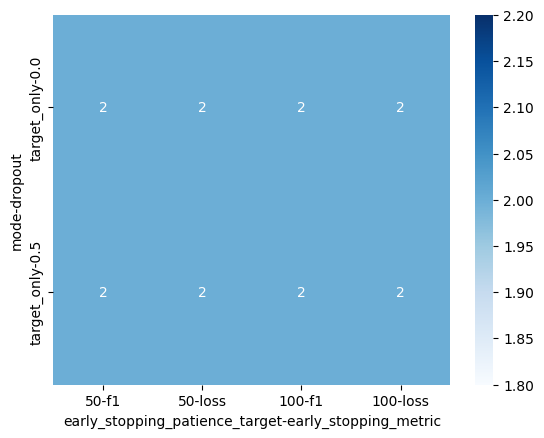

In [105]:
"""
This block plots performance from entire experiments directory for something like a hyperparameter sweep.
"""
import os
import json
import pandas as pd
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from lib.models import TestModel
from lib.train_utils import compute_loss_and_f1,evaluate
from sklearn.metrics import classification_report

data = []

experiments_dir = f'./experiments'
device = 'cuda'

for experiment in tqdm(os.listdir(experiments_dir)):
    for run in os.listdir(f'{experiments_dir}/{experiment}'):
        if not os.path.exists(f'{experiments_dir}/{experiment}/{run}/metrics.json'):
            print(f'Skipping {experiments_dir}/{experiment}/{run} as no metrics.json')
            continue
        
        metrics = json.load(open(f'{experiments_dir}/{experiment}/{run}/metrics.json'))
        losses = json.load(open(f'{experiments_dir}/{experiment}/{run}/losses.json'))
        hyperparameters = json.load(open(f'{experiments_dir}/{experiment}/{run}/hyperparameters.json'))

        if experiment.startswith('base'):
            hyperparameters['mode'] = 'base'
            best_base_model_path = f'{experiments_dir}/{experiment}/{run}/best_base_model.pt'
            from lib.models import TestModel
            target_participant = hyperparameters['target_participant']
            data_path = hyperparameters['data_path']
            batch_size = hyperparameters['batch_size']
            criterion = nn.BCEWithLogitsLoss()
            target_test_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_test.pt'))
            target_testloader = DataLoader(target_test_dataset, batch_size=batch_size, shuffle=False)
            model = TestModel()
            model.load_state_dict(torch.load(best_base_model_path, map_location='cpu'))
            model.to(device)
            test_loss, test_f1 = compute_loss_and_f1(model, target_testloader, criterion, device=device)
            metrics['test_f1'] = test_f1
            metrics['test_loss'] = test_loss
        
        # TODO: compute absolute improvement for each finetune model, may need two consecutive loops

        data.append({
            **metrics,
            **hyperparameters,
            'experiment': experiment,
            'run': run
        })
df = pd.DataFrame(data)

def get_base_test_f1(row):
    if row['mode'] == 'base':
        return row['test_f1']
    else:
        base_row = df[df['experiment'] == row['base_experiment_prefix']]
        return base_row['test_f1'].iloc[0] if len(base_row) > 0 else None

df['base_test_f1'] = df.apply(get_base_test_f1, axis=1)
df['absolute_improvement'] = df['test_f1'] - df['base_test_f1']

combo_df = df.groupby(['mode','dropout','early_stopping_patience_target','early_stopping_metric']).size().reset_index(name='count')
pivot_df = combo_df.pivot_table(values='count', 
                                index=['mode','dropout'], 
                                columns=['early_stopping_patience_target','early_stopping_metric'], 
                                fill_value=0)

sns.heatmap(pivot_df, annot=True, cmap='Blues')

<Axes: xlabel='dropout', ylabel='best_val_f1'>

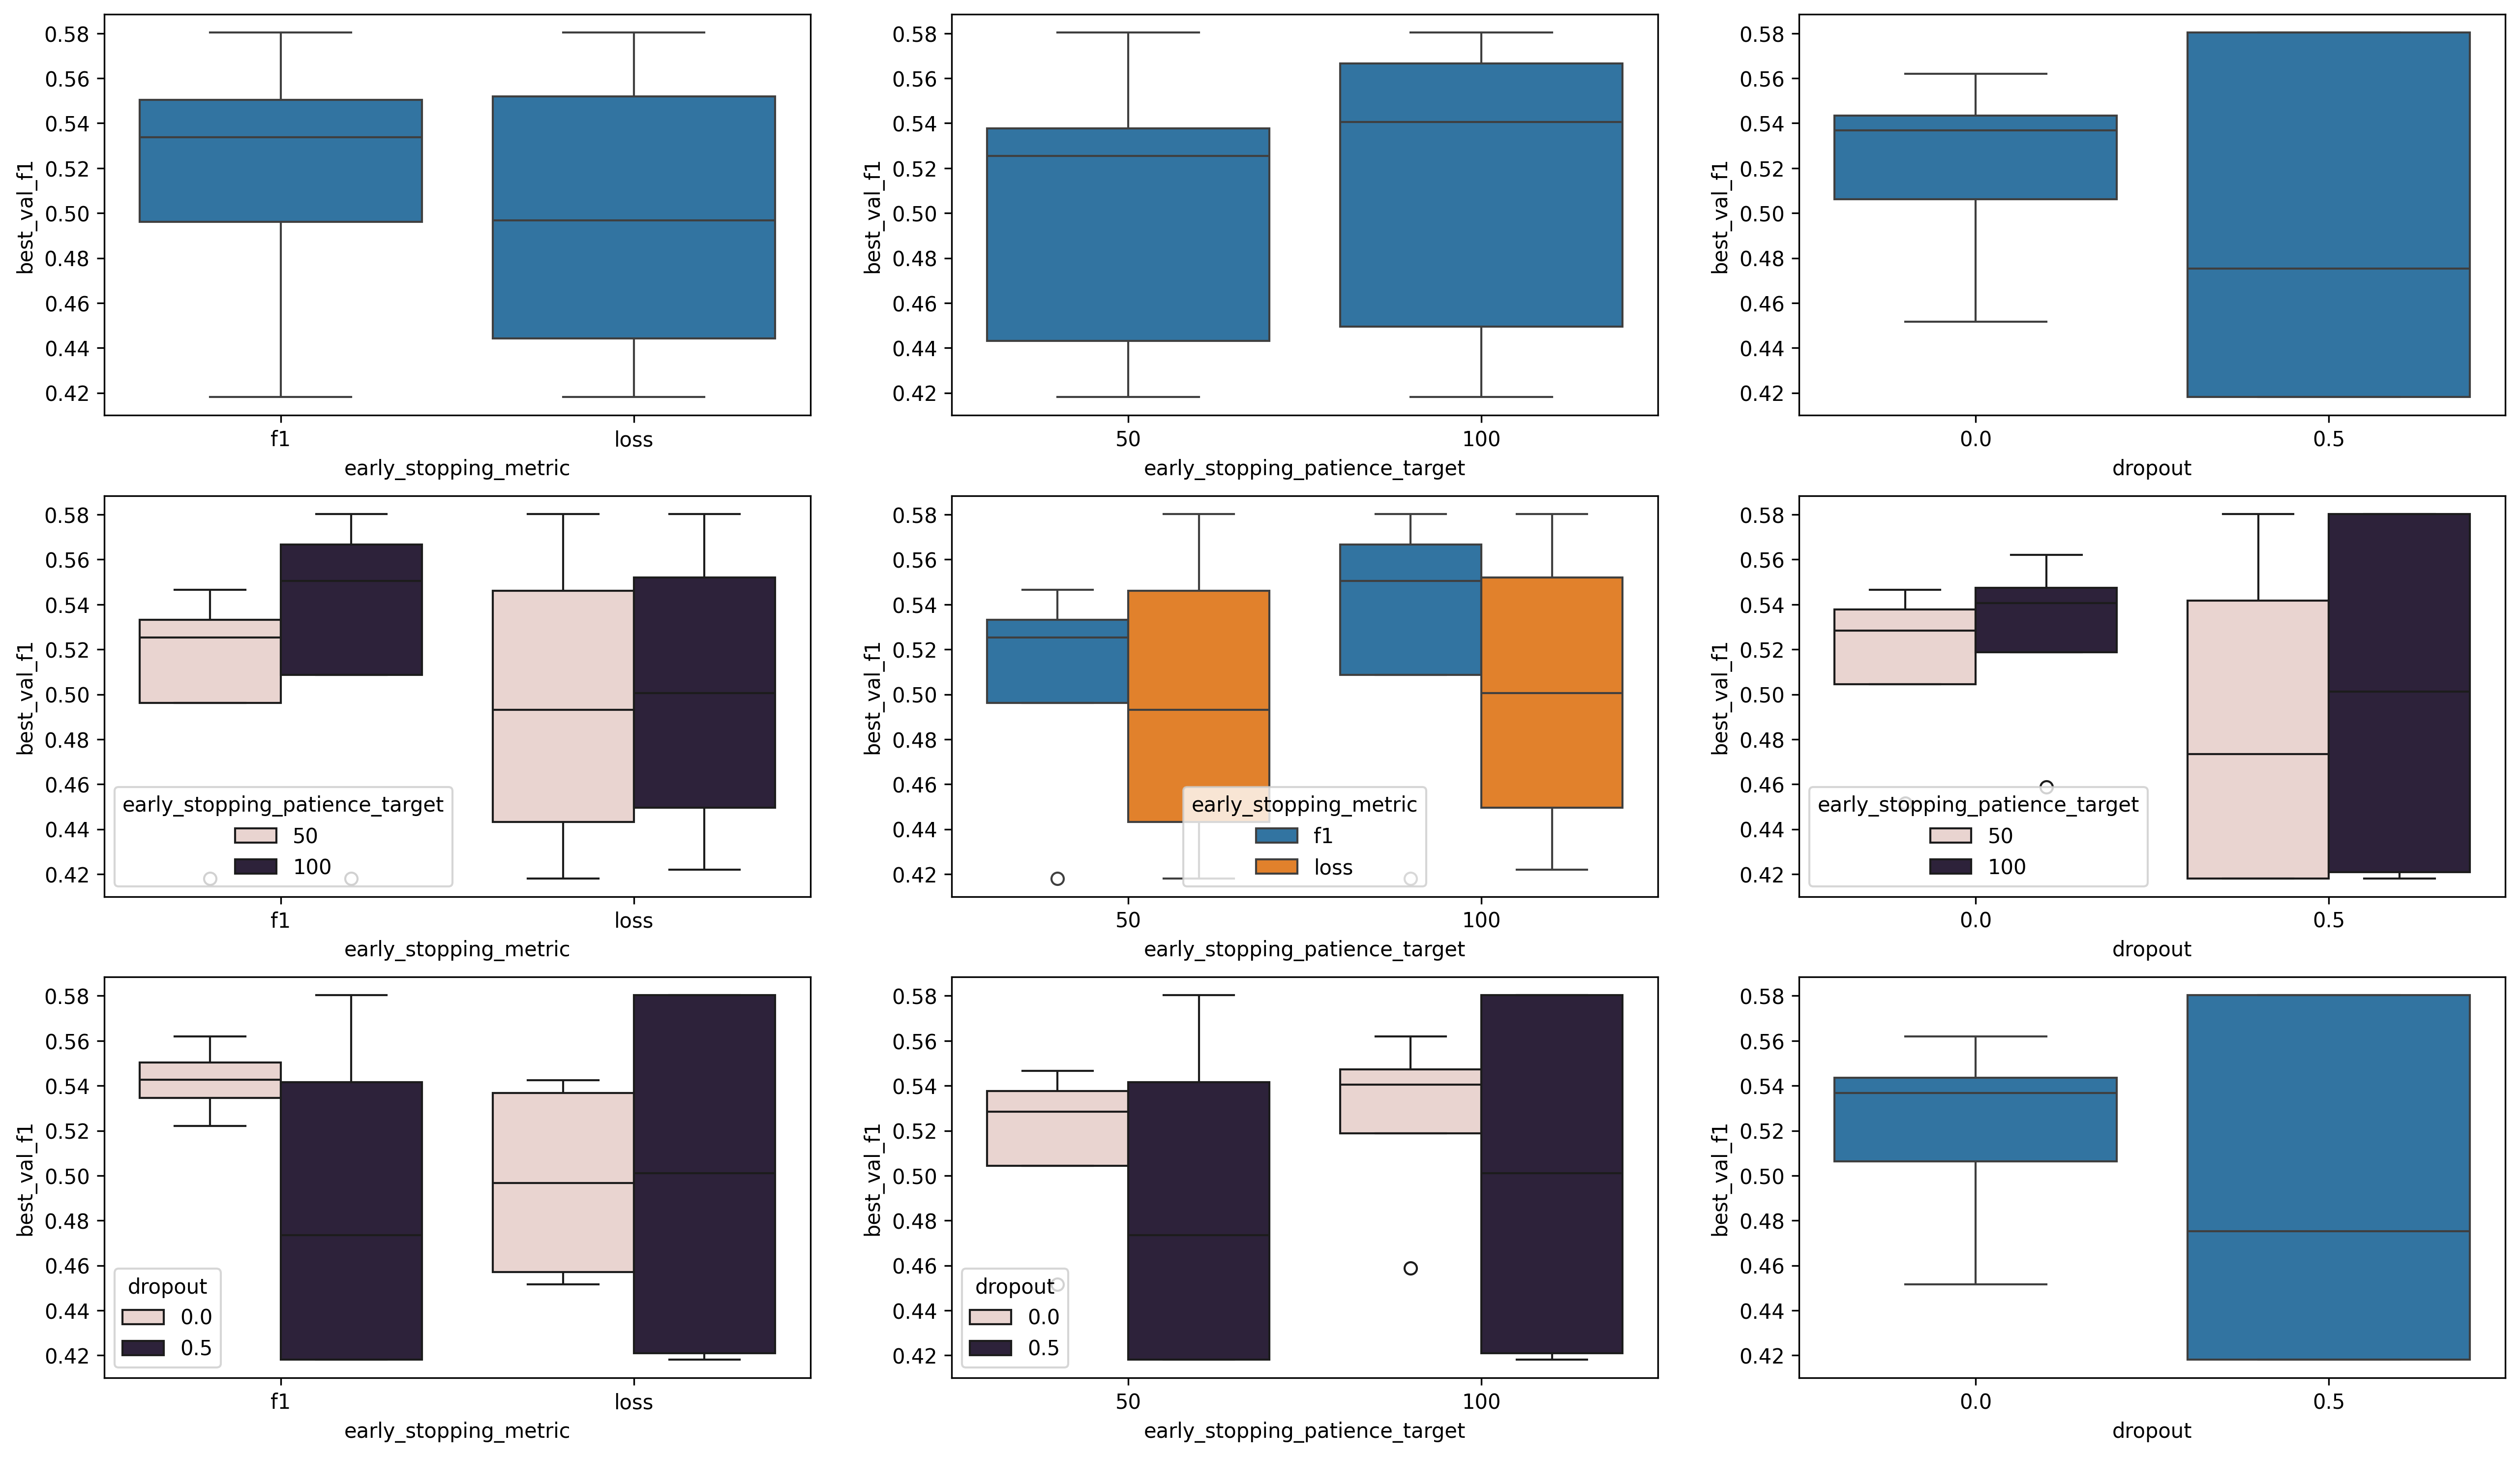

In [106]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(21, 12), dpi=300)

sns.boxplot(data=df, x='early_stopping_metric', y='best_val_f1', ax=ax[0,0])
sns.boxplot(data=df, x='early_stopping_metric', y='best_val_f1', hue='early_stopping_patience_target', ax=ax[1,0])
sns.boxplot(data=df, x='early_stopping_metric', y='best_val_f1', hue='dropout', ax=ax[2,0])

sns.boxplot(data=df, x='early_stopping_patience_target', y='best_val_f1', ax=ax[0,1])
sns.boxplot(data=df, x='early_stopping_patience_target', y='best_val_f1', hue='early_stopping_metric', ax=ax[1,1])
sns.boxplot(data=df, x='early_stopping_patience_target', y='best_val_f1',hue='dropout', ax=ax[2,1])

sns.boxplot(data=df, x='dropout', y='best_val_f1', ax=ax[0,2])
sns.boxplot(data=df, x='dropout', y='best_val_f1',hue='early_stopping_patience_target', ax=ax[1,2])
sns.boxplot(data=df, x='dropout', y='best_val_f1', ax=ax[2,2])

100%|██████████| 12/12 [00:00<00:00, 1873.57it/s]


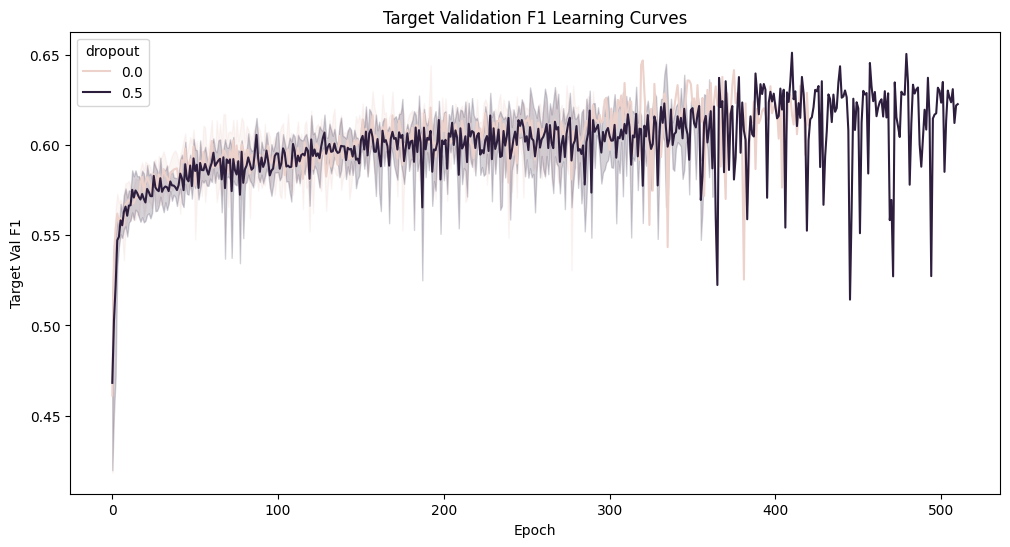

In [86]:
# Target val f1 learning curves
curve_data = []
for experiment in tqdm(os.listdir(experiments_dir)):
    for run in os.listdir(f'{experiments_dir}/{experiment}'):
        if not os.path.exists(f'{experiments_dir}/{experiment}/{run}/losses.json'):
            continue
        losses = json.load(open(f'{experiments_dir}/{experiment}/{run}/losses.json'))
        hyperparameters = json.load(open(f'{experiments_dir}/{experiment}/{run}/hyperparameters.json'))

        for epoch, f1 in enumerate(losses['val_f1']):
            curve_data.append({
                'epoch': epoch,
                'val_f1': f1,
                'val_loss': losses['val_loss'][epoch],
                'dropout': hyperparameters['dropout']
            })

curve_df = pd.DataFrame(curve_data)
plt.figure(figsize=(12, 6))
sns.lineplot(data=curve_df, x='epoch', y='val_f1', hue='dropout')
plt.title('Target Validation F1 Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Target Val F1')
plt.show()

<Axes: xlabel='seed', ylabel='test_f1'>

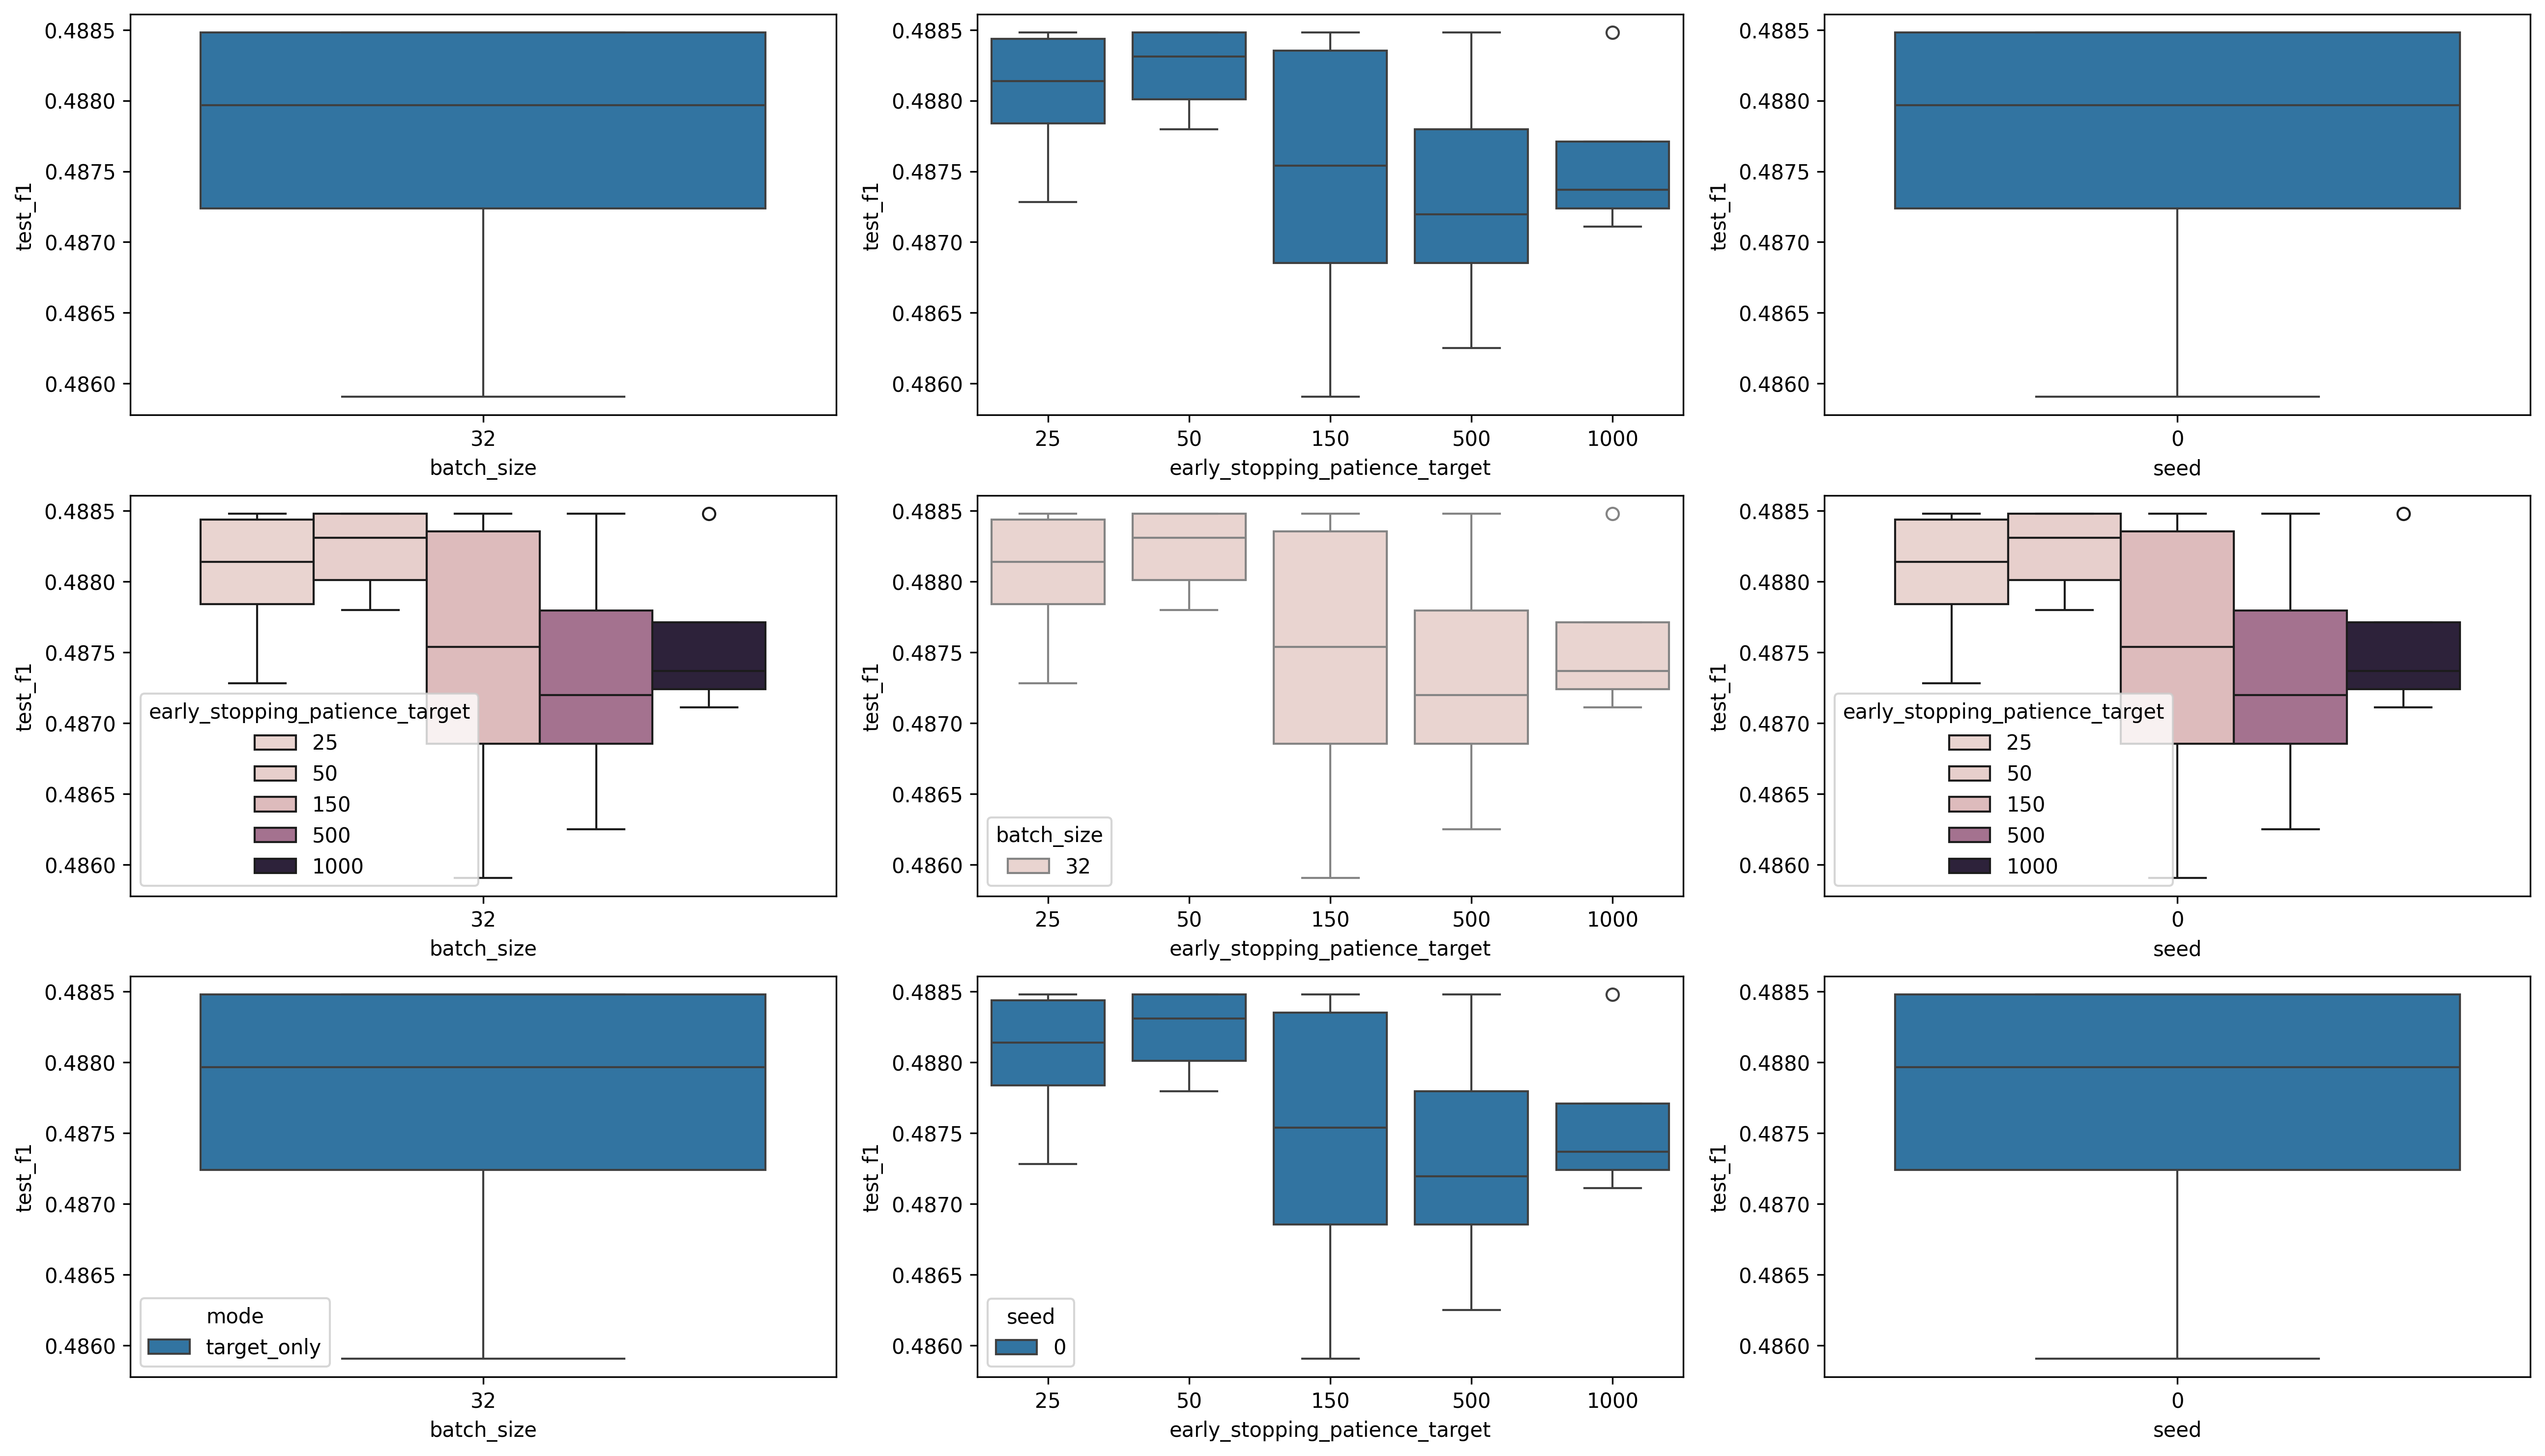

In [29]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(21, 12), dpi=300)

sns.boxplot(data=df, x='batch_size', y='test_f1', ax=ax[0,0])
sns.boxplot(data=df, x='batch_size', y='test_f1', hue='early_stopping_patience_target', ax=ax[1,0])
sns.boxplot(data=df, x='batch_size', y='test_f1', hue='mode', ax=ax[2,0])

sns.boxplot(data=df, x='early_stopping_patience_target', y='test_f1', ax=ax[0,1])
sns.boxplot(data=df, x='early_stopping_patience_target', y='test_f1', hue='batch_size', ax=ax[1,1])
sns.boxplot(data=df, x='early_stopping_patience_target', y='test_f1',hue='seed', ax=ax[2,1])

sns.boxplot(data=df, x='seed', y='test_f1', ax=ax[0,2])
sns.boxplot(data=df, x='seed', y='test_f1',hue='early_stopping_patience_target', ax=ax[1,2])
sns.boxplot(data=df, x='seed', y='test_f1', ax=ax[2,2])

In [10]:
df.sort_values('best_val_f1', ascending=False, inplace=True)

In [12]:
df.head(10)

,base_experiment_prefix,best_val_loss,best_val_loss_epoch,best_val_f1,best_val_f1_epoch,total_epochs,test_loss,test_f1,fold,device,...,data_path,n_base_participants,seed,seed_finetune,target_participant,experiment,run,base_model_hash,base_test_f1,absolute_improvement
15,NaN,0.043834,113,0.907315,135,163,0.240274,0.489291,8,0,...,data/001_60s_window,7,0,NaN,will,base_050d4ee87310dd5f,fold8_will,58a716cdae216f20,0.489291,0.000000
47,NaN,0.042875,193,0.907056,168,243,0.232254,0.489129,8,0,...,data/001_60s_window,7,2,NaN,will,base_b921d21190e05965,fold8_will,781630d0bda65546,0.489129,0.000000
7,NaN,0.043820,180,0.905369,221,230,0.251059,0.489210,8,0,...,data/001_60s_window,7,4,NaN,will,base_a887dad225e2d8c6,fold8_will,4b1ae10db4c4036b,0.489210,0.000000
49,NaN,0.044843,190,0.903648,208,240,0.249419,0.489372,8,1,...,data/001_60s_window,7,3,NaN,will,base_118314dfbca7cbdf,fold8_will,a8a5aba7a92f16ed,0.489372,0.000000
59,NaN,0.045688,112,0.902752,130,162,0.243411,0.489372,8,1,...,data/001_60s_window,7,1,NaN,will,base_7b2d425b41c8fa86,fold8_will,8d80a566602230fa,0.489372,0.000000
51,base_050d4ee87310dd5f,0.075386,51,0.656709,31,551,0.173883,0.526030,8,1,...,data/001_60s_window,7,0,10.0,will,finetune_3399262d8e1f06ae,fold8_will,NaN,0.489291,0.036739
40,base_050d4ee87310dd5f,0.075386,51,0.656709,31,301,0.173883,0.526030,8,1,...,data/001_60s_window,7,0,10.0,will,finetune_8e7025235e3dc6dd,fold8_will,NaN,0.489291,0.036739
34,base_050d4ee87310dd5f,0.076134,139,0.656709,211,264,0.171764,0.532122,8,1,...,data/001_60s_window,7,0,11.0,will,finetune_a17cd5c95f1b1152,fold8_will,NaN,0.489291,0.042831
35,base_050d4ee87310dd5f,0.075386,51,0.656709,31,176,0.173883,0.526030,8,0,...,data/001_60s_window,7,0,10.0,will,finetune_783664e38d39cf51,fold8_will,NaN,0.489291,0.036739
43,base_050d4ee87310dd5f,0.076134,139,0.656709,211,389,0.171764,0.532122,8,1,...,data/001_60s_window,7,0,11.0,will,finetune_234086444b14b443,fold8_will,NaN,0.489291,0.042831


<Axes: ylabel='test_f1'>

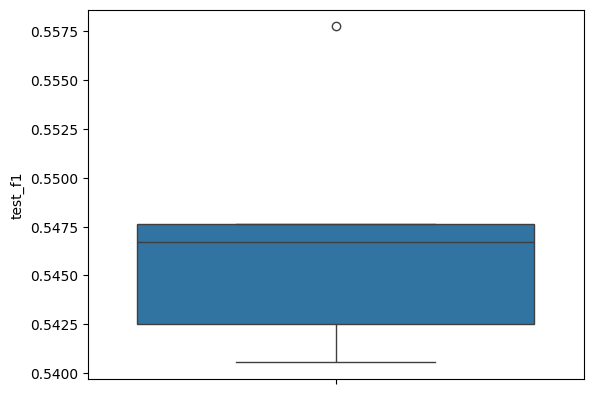

In [9]:
best_early_stopping_patience_target = 100 # determined from boxplot
best_batch_size = 32 # determined from boxplot
best_df = df[(df['early_stopping_patience_target'] == best_early_stopping_patience_target) & (df['batch_size'] == best_batch_size)]
sns.boxplot(data=best_df,y='test_f1') # boxplot of test f1 for best hyperparameters, distribution is across random seeds

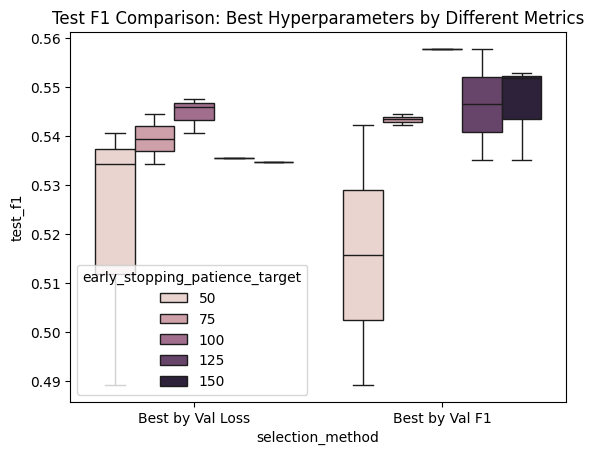

In [10]:
# Create combined dataset
best_by_loss = df.sort_values(by='best_val_loss', ascending=True).head(10).copy()
best_by_loss['selection_method'] = 'Best by Val Loss'

best_by_f1 = df.sort_values(by='best_val_f1', ascending=False).head(10).copy()
best_by_f1['selection_method'] = 'Best by Val F1'

combined_df = pd.concat([best_by_loss, best_by_f1])

# Single boxplot with hue
sns.boxplot(data=combined_df, x='selection_method', y='test_f1', hue='early_stopping_patience_target')
plt.title('Test F1 Comparison: Best Hyperparameters by Different Metrics')
plt.show()

<Axes: ylabel='best_val_f1'>

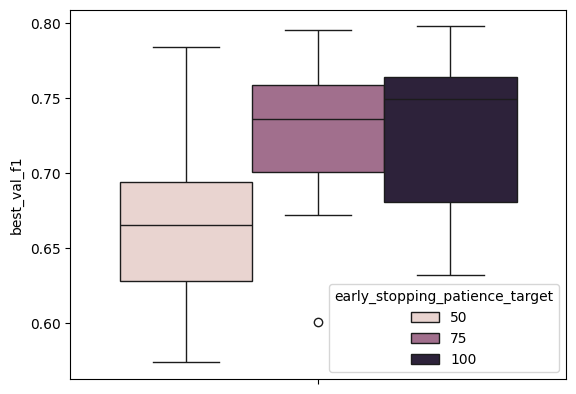

In [23]:
sns.boxplot(data=df,y='best_val_f1', hue='early_stopping_patience_target')

<Axes: xlabel='fold', ylabel='absolute_improvement'>

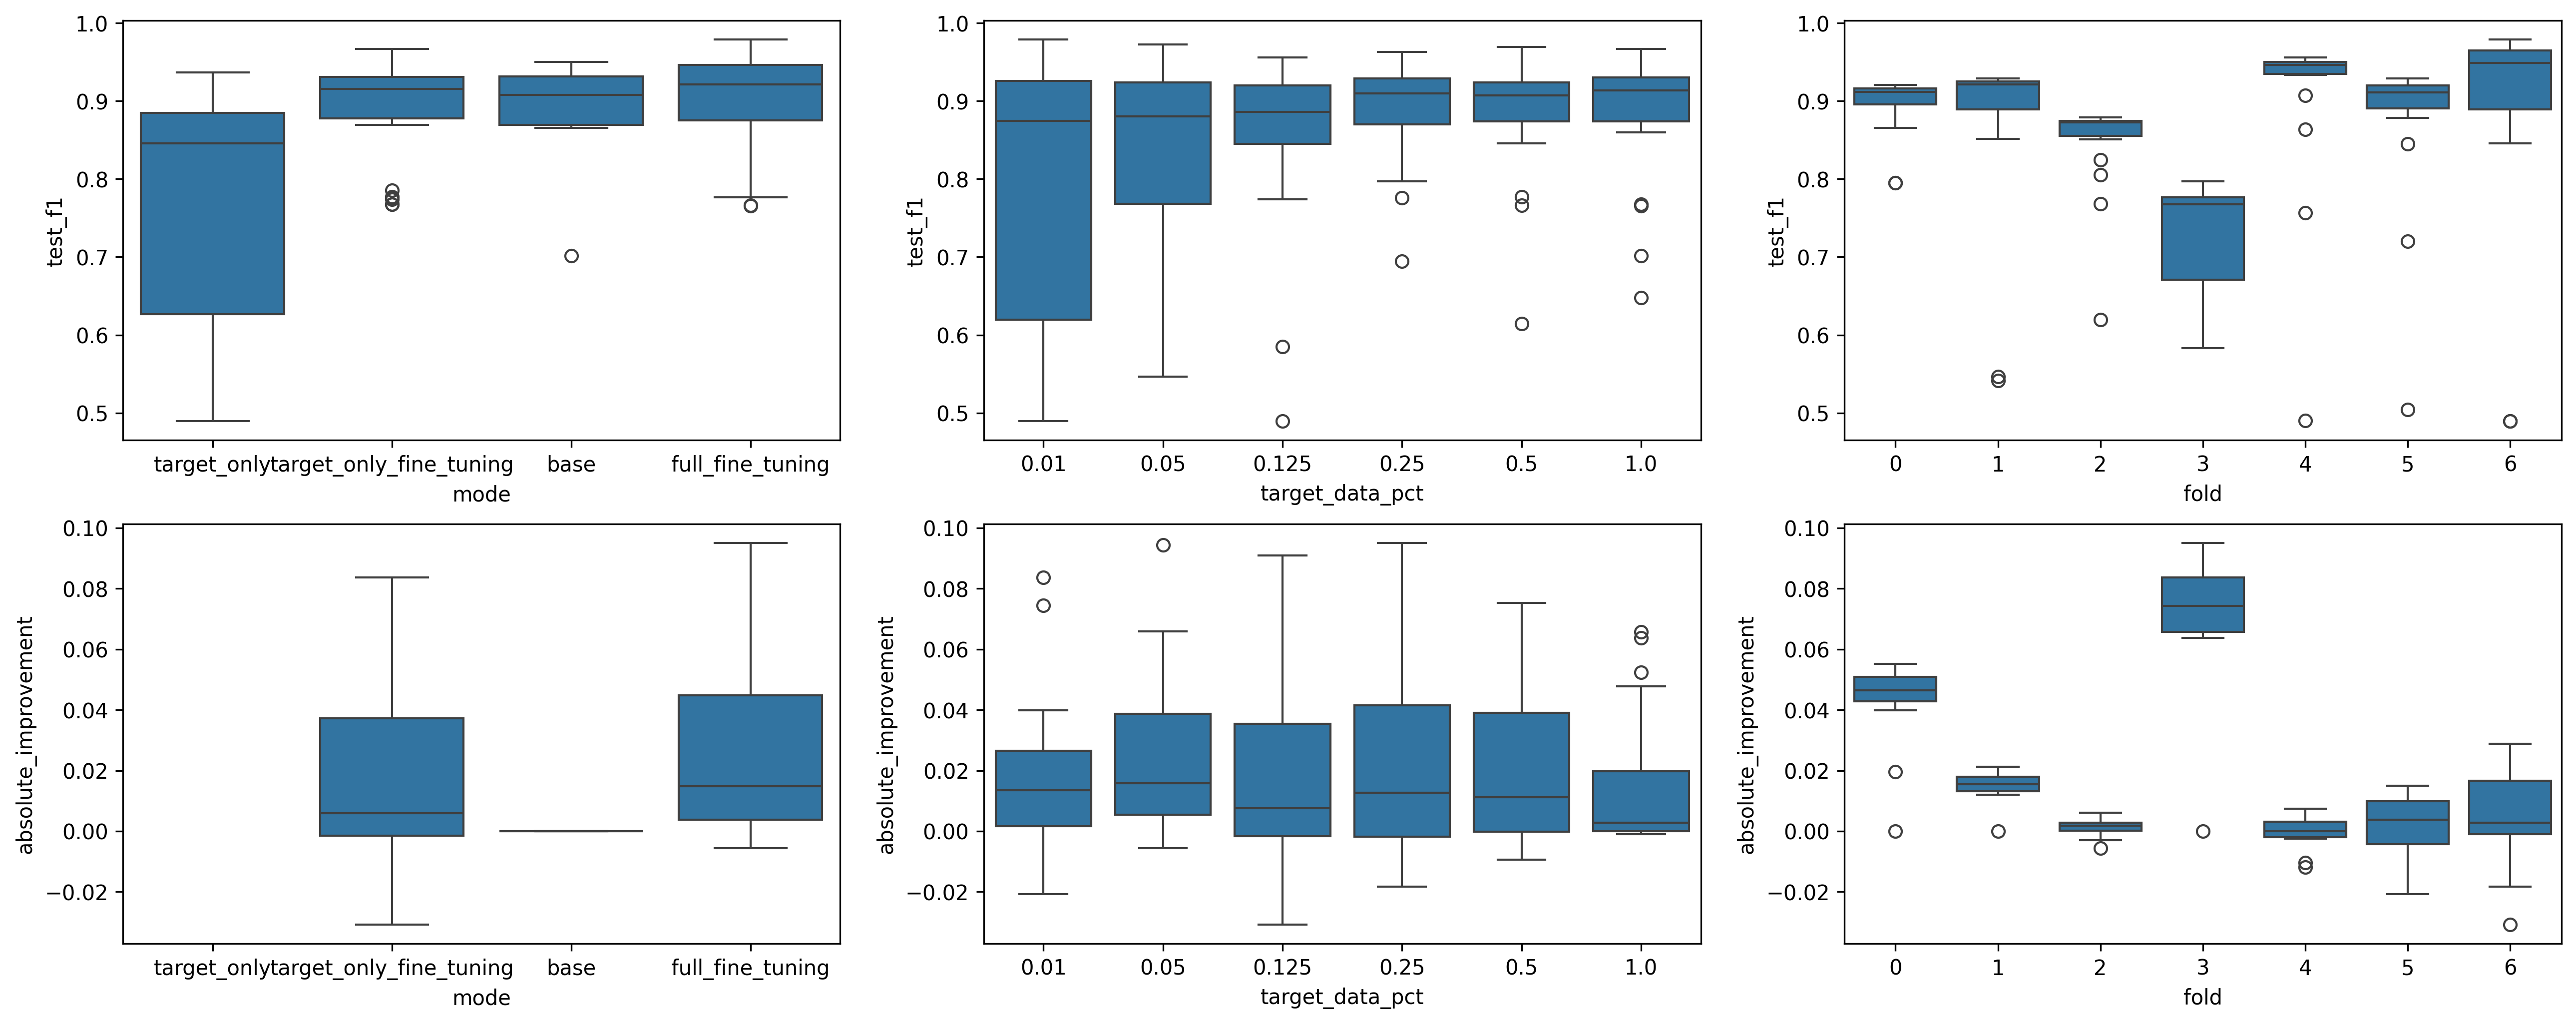

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(21, 8), dpi=300)

sns.boxplot(data=df, x='mode', y='test_f1', ax=ax[0,0])
sns.boxplot(data=df, x='target_data_pct', y='test_f1', ax=ax[0,1])
sns.boxplot(data=df, x='fold', y='test_f1', ax=ax[0,2])

sns.boxplot(data=df, x='mode', y='absolute_improvement', ax=ax[1,0])
sns.boxplot(data=df, x='target_data_pct', y='absolute_improvement', ax=ax[1,1])
sns.boxplot(data=df, x='fold', y='absolute_improvement', ax=ax[1,2])

<Axes: xlabel='fold', ylabel='absolute_improvement'>

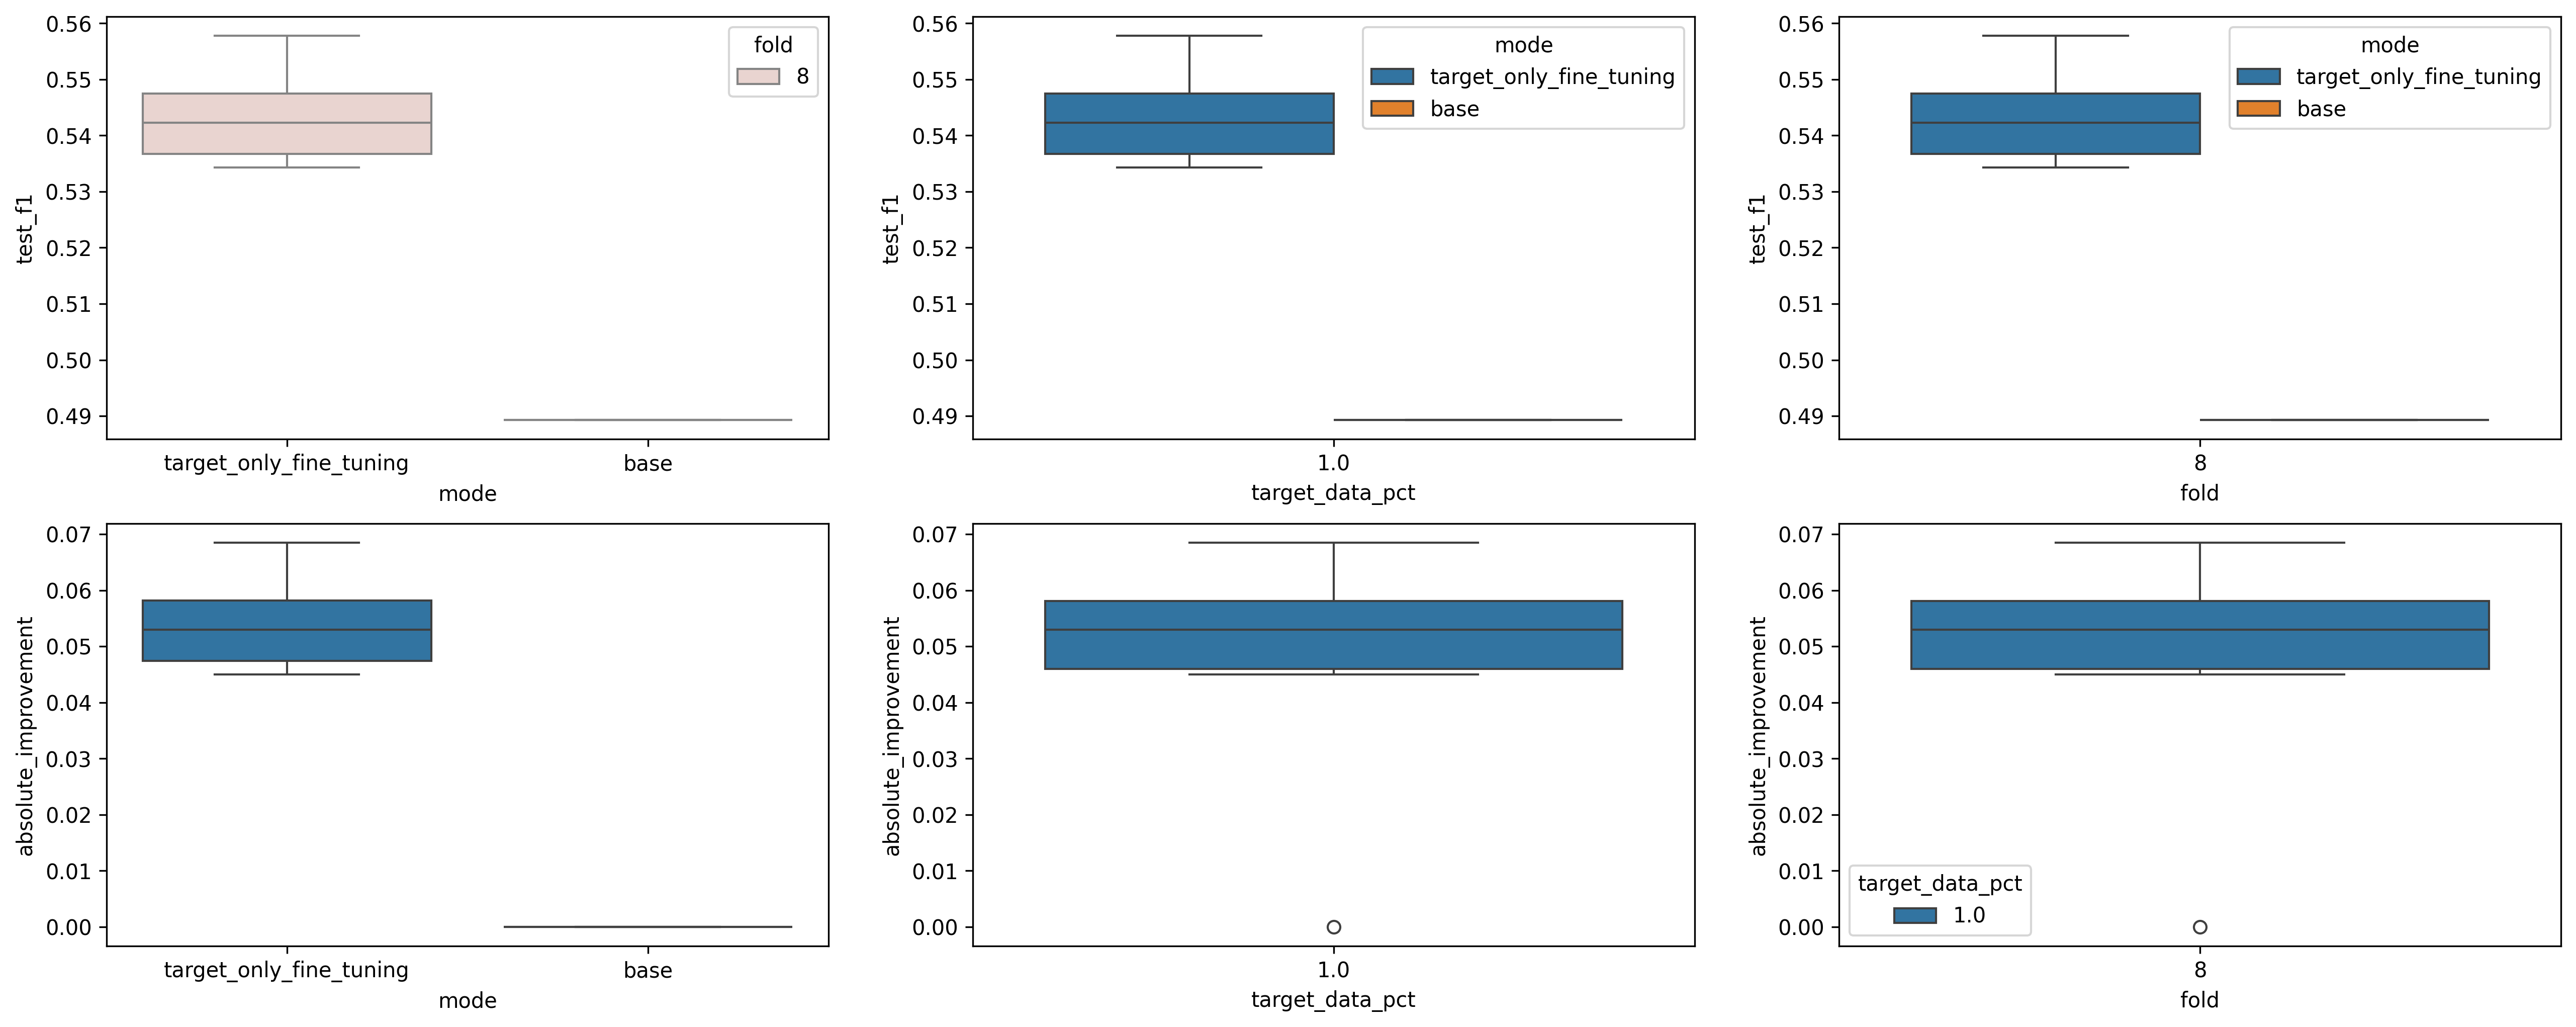

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(21, 8), dpi=300)

sns.boxplot(data=df, x='mode', y='test_f1', hue='fold', ax=ax[0,0])
sns.boxplot(data=df, x='target_data_pct', y='test_f1', hue='mode', ax=ax[0,1])
sns.boxplot(data=df, x='fold', y='test_f1', hue='mode', ax=ax[0,2])

sns.boxplot(data=df, x='mode', y='absolute_improvement', ax=ax[1,0])
sns.boxplot(data=df, x='target_data_pct', y='absolute_improvement', ax=ax[1,1])
sns.boxplot(data=df, x='fold', y='absolute_improvement', hue='target_data_pct', ax=ax[1,2])

In [11]:
def get_base_test_f1(row):
    if row['mode'] == 'base':
        return row['test_f1']
    else:
        base_row = df[df['experiment'] == row['base_experiment_prefix']]
        return base_row['test_f1'].iloc[0] if len(base_row) > 0 else None

df['base_test_f1'] = df.apply(get_base_test_f1, axis=1)
df['absolute_improvement'] = df['test_f1'] - df['base_test_f1']

# Do similar for difference between target only fine tuning and full fine tuning paired by base experiment
# Create a function to get the performance for each fine-tuning mode
def get_finetune_comparison(df):
    # Filter to only fine-tuning experiments (not base)
    finetune_df = df[df['mode'].isin(['target_only_fine_tuning', 'full_fine_tuning'])].copy()
    
    # Pivot to get both modes side by side for each base experiment
    comparison_df = finetune_df.pivot_table(
        values='test_f1', 
        index=['base_experiment_prefix', 'fold'], 
        columns='mode', 
        aggfunc='first'
    ).reset_index()
    
    # Calculate the difference (full - target_only)
    comparison_df['full_vs_target_only_diff'] = (
        comparison_df['full_fine_tuning'] - comparison_df['target_only_fine_tuning']
    )
    
    return comparison_df

# Get the comparison
finetune_comparison = get_finetune_comparison(df)

# Add this back to the main dataframe
df = df.merge(
    finetune_comparison[['base_experiment_prefix', 'fold', 'full_vs_target_only_diff']], 
    on=['base_experiment_prefix', 'fold'], 
    how='left'
)

# Now you can visualize which approach is better
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Box plot of the difference
sns.boxplot(data=finetune_comparison, y='full_vs_target_only_diff', ax=axes[0])
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0].set_title('Full Fine-tuning vs Target-only\n(Positive = Full Better)')
axes[0].set_ylabel('Performance Difference')

# Side-by-side comparison
finetune_melted = finetune_comparison.melt(
    id_vars=['base_experiment_prefix', 'fold'],
    value_vars=['target_only_fine_tuning', 'full_fine_tuning'],
    var_name='fine_tuning_mode',
    value_name='test_f1'
)
sns.boxplot(data=finetune_melted, x='fine_tuning_mode', y='test_f1', ax=axes[1])
axes[1].set_title('Performance by Fine-tuning Mode')

# Scatter plot showing paired comparison
sns.scatterplot(
    data=finetune_comparison, 
    x='target_only_fine_tuning', 
    y='full_fine_tuning',
    ax=axes[2]
)
axes[2].plot([0, 1], [0, 1], 'r--', alpha=0.7)  # Diagonal line
axes[2].set_title('Paired Comparison\n(Above line = Full Better)')
axes[2].set_xlabel('Target-only Fine-tuning F1')
axes[2].set_ylabel('Full Fine-tuning F1')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary of Fine-tuning Comparison:")
print(f"Mean difference (Full - Target-only): {finetune_comparison['full_vs_target_only_diff'].mean():.4f}")
print(f"Std of difference: {finetune_comparison['full_vs_target_only_diff'].std():.4f}")
print(f"Full fine-tuning better in {(finetune_comparison['full_vs_target_only_diff'] > 0).sum()} out of {len(finetune_comparison)} cases")

KeyError: 'full_fine_tuning'

<Axes: xlabel='mode', ylabel='test_f1'>

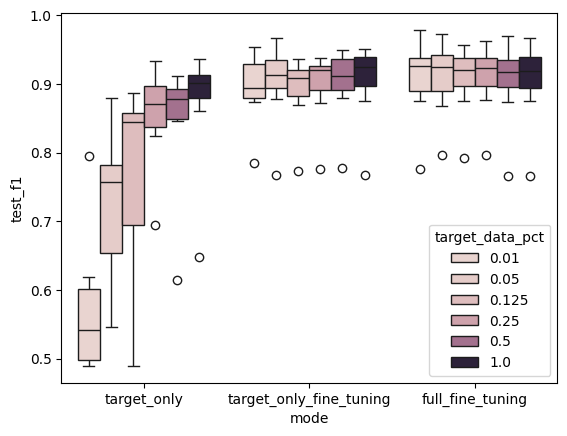

In [9]:
df_plot = df.copy()
df = df[df['mode'] != 'base']  # Exclude base for this plot because it has no target_data_pct
sns.boxplot(data=df, x='mode', y='test_f1', hue='target_data_pct')

In [ ]:
df_plot = df.copy()
sns.boxplot(data=df_plot, x='fold', y='best_target_model_target_val_f1', hue='mode')

In [ ]:
df_plot = df.copy()
# df_plot = df_plot[df_plot['mode'] == 'full_fine_tuning']
df_plot = df_plot[df_plot['target_data_pct'] == 1]
# df_plot = df_plot[df_plot['n_base_participants'] == 6]
df_plot = df_plot.melt(value_vars=['best_base_model_target_test_f1','best_target_model_target_test_f1'],id_vars=['fold','batch_size','target_data_pct','n_base_participants','mode'], var_name='metric', value_name='value')
sns.boxplot(data=df_plot, x='metric', y='value', hue='mode')

In [ ]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] == 'target_only_fine_tuning']
# df_plot = df_plot[df_plot['target_data_pct'] == 1]
# df_plot = df_plot[df_plot['n_base_participants'] == 6]
df_plot = df_plot.melt(value_vars=['best_base_model_target_test_f1','best_target_model_target_test_f1'],id_vars=['fold','batch_size','target_data_pct','n_base_participants','mode'], var_name='metric', value_name='value')
df_plot
sns.boxplot(data=df_plot, x='fold', y='value', hue='metric')

In [ ]:
sns.boxplot(data=df, x='mode', y='best_target_model_target_test_f1')

In [ ]:
sns.boxplot(data=df, x='mode', y='best_target_model_target_test_f1', hue='target_data_pct')

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(12,10))
sns.boxplot(data=df, x='target_data_pct', y='best_target_model_target_val_loss', ax=ax[0,0])
ax[0,0].set_yscale('log')
sns.boxplot(data=df, x='target_data_pct', y='best_target_model_target_val_f1', ax=ax[1,0])
sns.boxplot(data=df, x='batch_size', y='best_target_model_target_val_f1', hue='target_data_pct', ax=ax[0,1])
sns.boxplot(data=df, x='batch_size', y='best_target_model_target_val_loss', hue='target_data_pct', ax=ax[1,1])

In [ ]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] == 'target_only_fine_tuning']
# df_plot = df_plot[df_plot['target_data_pct'] == 1]
sns.boxplot(data=df_plot, x='n_base_participants', y='best_target_model_target_test_f1')

In [8]:
df

,base_experiment_prefix,best_val_loss,best_val_loss_epoch,best_val_f1,best_val_f1_epoch,total_epochs,test_loss,test_f1,fold,device,...,window_size,data_path,n_base_participants,target_participant,experiment,run,base_model_hash,base_test_f1,absolute_improvement,full_vs_target_only_diff
0,None,0.153537,143,0.665829,190,193,0.074779,0.756419,4,0,...,3000,data/001_60s_window,all,ejaz,target_only_10f26f0ab1112d02,fold4_ejaz,NaN,NaN,NaN,NaN
1,None,0.092881,193,0.880634,85,243,0.828771,0.546337,1,0,...,3000,data/001_60s_window,all,asfik,target_only_10f26f0ab1112d02,fold1_asfik,NaN,NaN,NaN,NaN
2,None,0.201209,137,0.687591,187,187,0.143825,0.587918,3,0,...,3000,data/001_60s_window,all,anam,target_only_10f26f0ab1112d02,fold3_anam,NaN,NaN,NaN,NaN
3,None,0.075286,315,0.730541,247,365,0.065570,0.879965,6,0,...,3000,data/001_60s_window,all,unk1,target_only_10f26f0ab1112d02,fold6_unk1,NaN,NaN,NaN,NaN
4,None,0.075528,137,0.742868,183,187,0.052689,0.719878,5,1,...,3000,data/001_60s_window,all,iftakhar,target_only_10f26f0ab1112d02,fold5_iftakhar,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,None,0.152211,314,0.810184,334,364,0.104537,0.694480,3,1,...,3000,data/001_60s_window,all,anam,target_only_d57d066e70207e85,fold3_anam,NaN,NaN,NaN,NaN
121,None,0.049148,193,0.862869,172,243,0.070744,0.848561,6,1,...,3000,data/001_60s_window,all,unk1,target_only_d57d066e70207e85,fold6_unk1,NaN,NaN,NaN,NaN
122,None,0.042232,185,0.866400,233,235,0.032921,0.887126,5,0,...,3000,data/001_60s_window,all,iftakhar,target_only_d57d066e70207e85,fold5_iftakhar,NaN,NaN,NaN,NaN
123,None,0.076414,255,0.888951,259,305,0.067661,0.906696,0,0,...,3000,data/001_60s_window,all,tonmoy,target_only_d57d066e70207e85,fold0_tonmoy,NaN,NaN,NaN,NaN


In [25]:
df[df['experiment'] == 'base_27ae31959dda4c42']

,base_experiment_prefix,best_val_loss,best_val_loss_epoch,best_val_f1,best_val_f1_epoch,total_epochs,test_loss,test_f1,fold,device,...,participants,window_size,data_path,n_base_participants,target_participant,experiment,run,base_model_hash,base_test_f1,absolute_improvement
23,NaN,0.046905,123,0.902884,149,173,0.020565,0.949901,6,1,...,"[tonmoy, asfik, alsaad, anam, ejaz, iftakhar, ...",3000,data/001_60s_window,6,unk1,base_27ae31959dda4c42,fold6_unk1,d5d95b994c0e2f4d,0.949901,0.0


In [32]:
df.loc[df['mode'] == 'base','test_f1'].mean()

np.float64(0.8800772888610379)

In [24]:
df.groupby('experiment')['test_f1'].mean().sort_values(ascending=False)

experiment
base_27ae31959dda4c42           0.949901
base_cc8880666f5875c4           0.948427
base_068ebd4b4373e782           0.914161
finetune_4abb50bf459cd37c       0.908085
base_f06dc33cdc351160           0.907845
finetune_27973c3b012ace93       0.905278
finetune_3cd562e14f2ad3d7       0.902511
finetune_bcfd626bbeee34dc       0.902000
finetune_799b1d8ce0048393       0.901885
finetune_92f733785545a292       0.900529
finetune_85341c05d1a9cc48       0.899148
finetune_16da73e1e45d3170       0.897840
finetune_0cd2204ea7c1ca8a       0.895643
finetune_5b5635fb5492a439       0.892718
finetune_24c53bf385240ec9       0.889166
finetune_1775ba93f2b9bf75       0.877400
base_df6d877e48a3a9ac           0.872651
target_only_57c476205f6f94ed    0.867299
base_d3c24088bad36719           0.865795
target_only_d57d066e70207e85    0.852123
target_only_2e36a01dc507719e    0.840908
target_only_14895459e6dad38c    0.760764
target_only_10f26f0ab1112d02    0.721989
base_f0a7c77d575a0bfd           0.701761
targe

In [ ]:
best_model_hash = df.groupby('hyperparameter_hash')['best_target_model_target_val_f1'].mean().sort_values(ascending=False).keys()[0]
print(best_model_hash)
df_metrics = df[df['hyperparameter_hash'] == best_model_hash].copy()
# Compute Metrics For Paper
display(df_metrics)
df_metrics = df_metrics[['fold','best_base_model_target_test_f1','best_target_model_target_test_f1']]
df_metrics.sort_values('fold', inplace=True)
# Add Absolute Improvement
df_metrics['absolute_improvement'] = df_metrics['best_target_model_target_test_f1'] - df_metrics['best_base_model_target_test_f1']
# Add Relative Improvement
df_metrics['relative_improvement'] = df_metrics['absolute_improvement'] / df_metrics['best_base_model_target_test_f1']
# Add Room For Improvement Metric
df_metrics['room_for_improvement'] = (1 - df_metrics['best_base_model_target_test_f1'])
df_metrics['room_for_improvement_pct'] = df_metrics['absolute_improvement'] / df_metrics['room_for_improvement']

In [ ]:
from lib.models import TestModel
from lib.train_utils import compute_loss_and_f1,evaluate
from sklearn.metrics import classification_report
from lib.train_utils import random_subsample
device = 'cpu'

# Load Model From Best Model Hash
# You can change this to load a different model if you want to inspect it
best_model_dir = [d for d in os.listdir(experiments_dir) if best_model_hash in d][0]
print(f'Loading model from {best_model_dir}')

run_dirs = os.listdir(f'{experiments_dir}/{best_model_dir}')
print(f'Runs: {run_dirs}')

df_metrics['best_target_model_target_test_precision'] = 0.0
df_metrics['best_target_model_target_test_recall'] = 0.0

for run_dir in run_dirs:
    print(f'Loading model from {run_dir}')
    best_base_model_path = f'{experiments_dir}/{best_model_dir}/{run_dir}/best_base_model.pt'

    criterion = nn.BCEWithLogitsLoss()
    hyperparameters = json.load(open(f'{experiments_dir}/{best_model_dir}/{run_dir}/hyperparameters.json'))
    target_participant = hyperparameters['target_participant']
    data_path = hyperparameters['data_path']
    batch_size = hyperparameters['batch_size']
    fold = hyperparameters['fold']
    print(f'Loading data from {data_path} for target participant {target_participant}')
    target_train_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_train.pt'))
    target_val_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_val.pt'))
    target_test_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_test.pt'))

    # Subsample target training data if specified
    target_data_pct = hyperparameters['target_data_pct']
    if target_data_pct < 1.0:
        print(f'Target train dataset size: {len(target_train_dataset)}')
        target_train_dataset = random_subsample(target_train_dataset, target_data_pct)
        print(f'Target train dataset size: {len(target_train_dataset)}')

    print(f'Target val dataset size: {len(target_val_dataset)}')
    target_val_dataset = random_subsample(target_val_dataset, .1)
    print(f'Target val dataset size: {len(target_val_dataset)}')

    target_trainloader = DataLoader(target_train_dataset, batch_size=batch_size, shuffle=True)
    target_valloader = DataLoader(target_val_dataset, batch_size=batch_size, shuffle=False)
    target_testloader = DataLoader(target_test_dataset, batch_size=batch_size, shuffle=False)

    model = TestModel()
    print(f'Loading base model from {best_base_model_path}')
    model.load_state_dict(torch.load(best_base_model_path, map_location='cpu'))
    model.to(device)

    test_loss, test_f1 = compute_loss_and_f1(model, target_testloader, criterion, device=device)
    y_true,y_pred = evaluate(model, target_testloader, device=device)

    report = classification_report(y_true, y_pred, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']

    df_metrics.loc[df_metrics['fold'] == fold,'best_target_model_target_test_precision'] = precision
    df_metrics.loc[df_metrics['fold'] == fold,'best_target_model_target_test_recall'] = recall

In [ ]:
# Target val f1 learning curves
curve_data = []
for experiment in tqdm(os.listdir(experiments_dir)):
    for run in os.listdir(f'{experiments_dir}/{experiment}'):
        if not os.path.exists(f'{experiments_dir}/{experiment}/{run}/losses.json'):
            continue
        losses = json.load(open(f'{experiments_dir}/{experiment}/{run}/losses.json'))
        hyperparameters = json.load(open(f'{experiments_dir}/{experiment}/{run}/hyperparameters.json'))

        if hyperparameters['mode'] != 'full_fine_tuning':
            continue
        
        for epoch, f1 in enumerate(losses['target val f1']):
            curve_data.append({
                'epoch': epoch,
                'target_val_f1': f1,
                'fold': run
            })

curve_df = pd.DataFrame(curve_data)
plt.figure(figsize=(12, 6))
sns.lineplot(data=curve_df, x='epoch', y='target_val_f1', hue='fold')
plt.title('Target Validation F1 Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Target Val F1')
plt.show()